## Part 0: Preliminaries

### Part 0.1: imports & constants

In [93]:
#for cleaner output in notebook, of course won't be triggered in the library
import warnings
warnings.filterwarnings('ignore')

#library dependencies
import numpy as np
import music21 as m21
import pretty_midi as pm
import drawSvg as draw
#drawSvg needs cairosvg in order to output png file. Can work without, if only svg files are used.
from librosa.feature import chroma_stft
from scipy.io import wavfile

#all part of the python standard library
import tempfile
import math
import os
import matplotlib.pyplot as plt

#for display and the bonus part. 
from PIL import Image
from IPython.display import display

test_midi_folder = 'midiFiles/'
test_audio_folder = 'audioFiles/'


bach_prelude_midi = test_midi_folder + '210606-Prelude_No._1_BWV_846_in_C_Major.mid'
faust_symphony_midi = test_midi_folder+'Faust_Symphony_mov1.mid'
ave_maria_midi = test_midi_folder+'AveMaria_desPrezmid.mid'
giant_steps_midi = test_midi_folder+'giant_steps_first_chorus.mid'
ligeti_midi = test_midi_folder+'38088_Ligeti-Etude-No-2-Cordes-a-vide.mid'
chopin_midi = test_midi_folder+'chopin-prelude-op28-2.mid'
scriabin_midi = test_midi_folder+'Op74_No2_Pure.mid'

filenames = [faust_symphony_midi, scriabin_midi, giant_steps_midi,\
             bach_prelude_midi, ave_maria_midi, ligeti_midi, chopin_midi]


### Part 0.2: Test functions

In [2]:
def test(assertion, test_name, test_logger):
    test_logger[test_name] = assertion

def test_bilan(test_logger):
    all_good = True
    failed_tests = [k for k,v in test_logger.items() if not v]
    test_nmbr = len(test_logger.items())
    if len(failed_tests) > 0:
        print("%d out of %d tests failed. The failed tests are: "%(len(failed_tests), test_nmbr))
        for s in failed_tests:
            print('-'+s)
    else:
        print("All %d tests succeeded."%test_nmbr)

# Part 1: file to list of PCVs 

## Part 1.1 code

In [3]:
twelve_tones_vector_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#','A', 'A#', 'B']

#this is to correct the name found in the outputed notes from music21 parsiing 
#of MIDI files.
altered_notation_dict = {
    'B#' : 'C',
    'D-' : 'C#',
    'E-' : 'D#',
    'F-' : 'E',
    'E#' : 'F',
    'G-' : 'F#',
    'A-' : 'G#',
    'B-' : 'A#',
    'C-' : 'B'
} 

pitch_pitch_dict = {x: x for x in twelve_tones_vector_name}

#In the end we want each string to match an index between 0 and 11, so it fits inside a 12-d vector.
pitch_index_dict = {twelve_tones_vector_name[i]:i for i in range(len(twelve_tones_vector_name))}

#So any pitch name given to this dict will be mapped to its cannonical form defined in 'twelve_tones_vector_name'
normalize_notation_dict = dict(altered_notation_dict,  **pitch_pitch_dict)

def recursively_map_offset(filepath, only_note_name=True):
    '''
    This function recursively walks through the file's  stream's elements, 
    and whenever it encounters a note, it will append its rhytmic 
    data to the pitch and then store the resulting data structure in an array.
    If a music21 element of type chord is encountered, the chord is decomposed into all
    notes it is composed by, and each of thoses notes are appended the 
    Returns the aforementionned array.
    The rhytmic data is expressed as a tuple of the offset of the beginning of the note
    and the offset of the end of the note.
    
    All temporal informations from MIDI events parsed by the music21 library are encoded
    as unit of quarter notes count, regardless of the BPM+ or the time signature.
    
    Parameters
    ----------
    filepath : str
        the path of the MIDI file to be parsed into the list of pitches and time offset.
        
    only_note_name: bool, optional 
        indicates whether the notes need to be converted from music21 object with octave indication
        to only a string indicating the pitch class name. 
        Default value is True.
        
    Returns
    -------
    iterable of tuples
        the first element of each tuple from this iterable can either be a string indicating the 
        pitch class name of an occurence of one note, or an instance of music21.note representing 
        the occurence of one note, if the parameters 'only_note_name' is set to 'False'. 
        The second half of the tuple, is a tuple itself of float values, the first indicating
        the start offset in time of the note's occurrence, while the second indicates the end
        offset in time of the note's occurrence. Both values are expressed in terms of quarter 
        note length.
        '('E', (10,11,5))' for example would be one element of this iterable, representing an E note
        which starts at the 10th quarter note of the MIDI file and stops one quarter note and half
        later in the piece. 
        
    
    '''
    midi_stream = m21.converter.parse(filepath)
    res = []
    for elem in midi_stream.recurse():
        if isinstance(elem, m21.note.Note):
            start_offset = elem.getOffsetInHierarchy(midi_stream)
            res.append((elem.name if only_note_name else elem, (start_offset, start_offset+elem.duration.quarterLength)))
        elif isinstance(elem, m21.chord.Chord):
            start_offset = elem.getOffsetInHierarchy(midi_stream)
            res += list(map(lambda r: (r.name if only_note_name else r , (start_offset, start_offset+elem.duration.quarterLength)), elem.pitches))
    return res


def remove_drums_from_midi_file(midi_filepath):
    '''
    Takes care of removing drum tracks from a midi filename.
    Work only if the MIDI file has metadata clearly indicating channels that are
    percussive. Does not remove channels of percussive instruments that are pitched
    (like the glockenspiel or the xylophone for instance).  
    
    Parameters
    ----------
    midi_filepath : str  
        the file path of the MIDI file that needs to have percussive channels removed. 
    
    Returns
    -------
    str
        A file path of the same midi file generated without the percussive channels.
        This file path leads to a temporary folder generated on the user's OS file system
        The existence of such temporary folder can not be guaranteed to last for a long
        span of time, this depends on the user's OS bahvior fir temporary folder. As such,
        the resulting file should be used as soone as possible, or moved to a permanet folder.
    
    '''
    sound = pm.PrettyMIDI(midi_filepath)
    
    #getting the track indices of unpitched "percussive" tracks. 
    drum_instruments_index = [idx for idx, instrument in enumerate(sound.instruments) if instrument.is_drum]
    for i in sorted(drum_instruments_index, reverse=True):
        del sound.instruments[i]

    folder = tempfile.TemporaryDirectory()
    temp_midi_filepath = folder.name+'tmp.mid'
    sound.write(temp_midi_filepath)
    
    return temp_midi_filepath

def slice_according_to_beat(pitch_offset_list, beat1_offset, beat2_offset):
    '''
    the beat offset must be expressed as units of quarter notes. 
    Taken are all beat which at least END AFTER the beat1, and START BEFORE the beat2
    '''
    def only_keep_pitches_in_boundaries(pitch_offset_list, beat1_offset, beat2_offset): 
        return list(filter(lambda n: n[1][1] >= beat1_offset and n[1][0] <= beat2_offset, pitch_offset_list))

    res = []
    if beat1_offset >= beat2_offset:
        return res
    for n in only_keep_pitches_in_boundaries(pitch_offset_list, beat1_offset, beat2_offset):
        start_b = n[1][0]
        end_b = n[1][1]
        
        res_n = None
        if start_b >= beat1_offset:
            if end_b > beat2_offset:
                res_n = (n[0], (start_b, beat2_offset))
            else:
                res_n = (n[0], (start_b, end_b))
        elif end_b <= beat2_offset:
            #if start_b < beat1_offset: #of course we are in this case since the first if was not triggered.
            res_n = (n[0], (beat1_offset, end_b))
        else:
            #we are thus in the case the start and end time of the note overshoot the boundaries.
            res_n = (n[0], (beat1_offset, beat2_offset))
        #normally inconsistent results should not happen, but it is possible to have a note with duration equals to 0. This line below prevents that and thus keep the things concise.
        if res_n[1][0] < res_n[1][1]:
            res.append(res_n)
    return res

def sum_into_pitch_class_vector(pitch_offset_list, start_beat, end_beat):
    pitch_class_offset = lambda t: pitch_index_dict[normalize_notation_dict[t[0]]]
    pitch_class_vec = np.zeros(12)
    for tup in pitch_offset_list:
        #we need to be sure we don't take into account the part of the note that exceed the window's size.
        min_beat = max(start_beat, tup[1][0])
        max_beat = min(end_beat, tup[1][1])
        pitch_weight = max_beat - min_beat
        pitch_class_vec[pitch_class_offset(tup)] += pitch_weight
    return pitch_class_vec


def get_max_beat(pitch_offset_list):
    return math.ceil(max(list(map(lambda r: r[1][1], pitch_offset_list))))

def pitch_class_set_vector_from_pitch_offset_list(pitch_offset_array, aw_size=0.5): #the analysis window size (aw_size) is expressed in terms of number of beat (quarter of measures in binary time signature).
    '''
    This functions transforms a list of tuples each containing the name of the pitch
    followed by its start and end in the file into a pitch class distribution with each
    pitch class given the weight corresponding to its duration in the current slice of
    temporal size aw_size.
    
    '''
    
    max_beat = get_max_beat(pitch_offset_array)
    
    if aw_size <= max_beat/2:
        chunk_number = math.ceil(max_beat/aw_size)
    else:
        raise Exception('The analysis window\'s size should not exceed half the duration of the musical piece.')
    
    res_vector = np.full((chunk_number, 12), 0.0, np.float64)

    for b in range(chunk_number):
        start_beat = b*aw_size
        stop_beat = (b+1)*aw_size
        analysis_windows = slice_according_to_beat(pitch_offset_array, start_beat, stop_beat)
        pitch_class_vec = sum_into_pitch_class_vector(analysis_windows, start_beat, stop_beat)
        res_vector[b] = pitch_class_vec
    
    return res_vector


# trim the input array so that no empty vectors are located at the beginning and end of the muscial piece
def trim_pcs_array(pcvs):
    start = 0
    while not np.any(pcvs[start]):
        start += 1
    end = len(pcvs) - 1
    while not np.any(pcvs[end]):
        end -= 1
    return pcvs[start:end+1]


def audio_int_to_float32(data, byte_width):
    return data.astype(np.float32, order='C') / float(2**(byte_width-1))
    
def audiowav_to_mono_float_array(filename):
    sr, data = wavfile.read(filename)
    data_dtype_str = str(data.dtype)
    if data_dtype_str[:3] == 'int':
        #converting the array into float
        data = audio_int_to_float32(data, int(data_dtype_str[3:]))
    elif data_dtype_str[:5] != 'float':
        raise Exception('wav audio data is not in a format that can (trivially) be converted into float32')
    channel_nbr = np.shape(data)[1]
    if channel_nbr > 1:
        #(super)stereo signal need to be converted into mono.
        data = data.sum(axis=1) / channel_nbr
    return data, sr

# "aw" in "number_of_aw" stands for analysis window. It determines how many chromagrams the signal will be discreticized into. 
def produce_chromagrams_from_audio_file(audio_filename, aw_size):
    audio_array, sample_ratio = audiowav_to_mono_float_array(audio_filename)
    
    hop_len = sample_ratio*aw_size #hop_len is the analysis window size for the chromagrams in terms of number of sample.
    #so the result's shape is consistent with the one produced in the case of midi files.
    return np.transpose(chroma_stft(audio_array, sample_ratio, hop_length=hop_len))

def produce_pitch_class_matrix_from_filename(filepath, remove_percussions = True, aw_size = 1., trim_extremities=True):
    '''
    This function takes a MIDI or WAV file as a parameters and
    transforms it into "list of pitch class distribution"
    This list is modelised by a Nx12 matrix of float values, each 
    row of the matrix corresponds to the pitch content of one slice
    of temporal size "aw_size" from the musical content from the
    input's file. The number of row N depends on the temporal size
    of the file, and the number chosen for aw_size.
    
    Parameters
    ----------
    filepath : str 
        the path of the MIDI/WAV file whose musical content 
        is transformed into the pitch class distribution's list
                 
    remove_percussions : bool, optional 
        indicates whether percussive instruments need to be removed from the mix. 
        ONLY APPLIES TO MIDI FILES CURRENTLY.
        Default value is True.
                          
    aw_size : float, optional
        means "analysis window's size", represent the size of each
        slice of pitch content from the file in terms of time. In the case 
        of MIDI file, this number represent the number of beat (a beat being
        a quarter note), and in the case of WAV file, this number represents 
        the number of seconds.
        Default value is 1 (1 quarter note, or 1 second depending on the file's type)
                
    trim_extremities : bool, optional
        inidicates whether the silences that are present at both
        extremities needs to be removed from the resulting list of pitch
        class distribution. ONLY APPLIES TO MIDI FILES CURRENTLY
        Default value is True.
        
    
    Returns
    -------
    numpy matrix of shape Nx12 (numpy.ndarray of numpy.float64)
        This matrix holds the pitch distributions corresponding to all
        the pitch content from all non overlapping slices of aw_size size from the file
        given as argument.
    
    '''
    if filepath.endswith('.mid') or filepath.endswith('.midi'):
        midi_filepath = remove_drums_from_midi_file(filepath) if remove_percussions else filepath
        pitch_offset_list = recursively_map_offset(midi_filepath)
        pcvs_arr = pitch_class_set_vector_from_pitch_offset_list(pitch_offset_list, aw_size)
        return trim_pcs_array(pcvs_arr) if trim_extremities else pcvs_arr
    elif filename.endswith('.wav'):
        return produce_chromagrams_from_audio_file(filename, aw_size)
    else:
        raise Exception('The file should be in MIDI or WAV format')
        
    return recursively_map_offset(midi_stream)

## Part 1.2 tests

In [4]:
test_logger = {}

if os.path.exists(bach_prelude_midi):

    #### MAX BEAT TEST
    BACH_PRELUDE_MAX_BEAT = 35 * 4
    bp_po_list = recursively_map_offset(bach_prelude_midi)
    test(BACH_PRELUDE_MAX_BEAT == get_max_beat(bp_po_list), \
         'Bach\'s Prelude has the right value for the max beat'\
         ,test_logger)

    #### DEFAULT AW SIZE TEST
    bp_pcm = produce_pitch_class_matrix_from_filename(bach_prelude_midi)
    test(np.shape(bp_pcm)[0] == BACH_PRELUDE_MAX_BEAT, \
         'Bach\'s Prelude parsed with default analysis window has \
         the right amount of beats', test_logger)

    #### AW SIZE = 1 TEST
    bp_pcm_aw1 = produce_pitch_class_matrix_from_filename(bach_prelude_midi, aw_size=1)
    test(np.shape(bp_pcm_aw1)[0] == BACH_PRELUDE_MAX_BEAT, \
         'Bach\'s Prelude parsed with unit analysis window has \
         the right amount of beats', test_logger)

    #### AW_SIZE = MAX_BEAT/2 
    bp_pcm_aw_half = produce_pitch_class_matrix_from_filename(bach_prelude_midi, aw_size=BACH_PRELUDE_MAX_BEAT/2)
    test(np.shape(bp_pcm_aw_half)[0] == 2, \
         'Bach\'s Prelude parsed with analysis window  of half the length of \
         the musical piece has the right amount of beats', test_logger)
else:
    test(False, 'No midi file exists for Bach\'s  Prelude in C Major (BWV 846)', test_logger)

    
    #### MIDI transcription of dummy musical piece with rest in the middle.
### This file is basically all quarter notes of the following pitch classes in sequences:
### E - G  - G - B - [full measure rest] - F - C - A - E
empty_space_midi = test_midi_folder + 'emptyspace.mid'
if os.path.exists(empty_space_midi):
    #### CONVERSION OF RESTS INTO EMPTY VECTOR
    e_mat = produce_pitch_class_matrix_from_filename(empty_space_midi, aw_size=1)
    are_empties_empty = not np.any(e_mat[4]) and not np.any(e_mat[5]) and  not np.any(e_mat[6]) and  not np.any(e_mat[7])
    test(are_empties_empty,\
         'dummy file with rests has rests parsed as null vectors',
        test_logger)
    are_notempties_not_empty = np.any(e_mat[3]) and np.any(e_mat[8])
    test(are_notempties_not_empty,\
         'dummy file with rests has notes parsed as non empty vectors',
        test_logger)
else:
    test(False, 'No midi file exists to test empty spaces in measures', test_logger)

    
### This midi file holds a soprano singer track, a drumset track, a triangle, 
### a hand clap and a tambourine track, as well as a xylophone track. Except the soprano and the xylophone,
### all tracks are considered percussive and not holding relevant pitch information. 
percussive_midi = test_midi_folder + 'NCandP.mid'
if os.path.exists(percussive_midi):

    #### REMOVING DRUM TRACKS FROM A MIDI FILE WITH 4 UNPITCHED PERCUSSIVE TRACKS TEST.
    count_midi_tracks = lambda fn: len(list(pm.PrettyMIDI(fn).instruments))
    ALL_TRACKS_NUMBER = 6
    PERCU_TRACKS_NUMBER = 4
    assert(count_midi_tracks(percussive_midi) == ALL_TRACKS_NUMBER)
    drumless_fn = remove_drums_from_midi_file(percussive_midi)
    
    test(count_midi_tracks(drumless_fn) == (ALL_TRACKS_NUMBER - PERCU_TRACKS_NUMBER),\
         'File with 4 drum tracks out of 6 got those tracks removed by function "remove_drums_from_midi_file"',
        test_logger)
else:
    test(False, 'No midi file exists to test the removal of percussive instruments', test_logger)

### Dummy midi track with few notes, and two empty measures at the beginning of the file. 
### this midi file describes a musical piece with 2 measures of rest at the beginning. 
### Produced to test the trim option from the midi to pcv matrix conversion's function.
trim_midi = test_midi_folder + 'trim_extremities_test.mid'
if os.path.exists(trim_midi):
    #### 'trim_extremities = True' DO TRIM THE EXTREMETIES.
    MEASURE_AW_SIZE = 4
    number_with_trim = np.shape(produce_pitch_class_matrix_from_filename(trim_midi, aw_size=MEASURE_AW_SIZE))[0]
    number_without_trim = np.shape(produce_pitch_class_matrix_from_filename(trim_midi, trim_extremities=False, aw_size=MEASURE_AW_SIZE))[0]
    test(number_with_trim == (number_without_trim - 2),\
         'File with 2 measures of rest at the beginning is trimmed by option "trim_extremities" from function "produce_pitch_class_matrix_from_filename"',
        test_logger)
else:
    test(False, 'No midi file exists to test the trim of empty measure at the beginnning and end of file', test_logger)

test_bilan(test_logger)


3 out of 7 tests failed. The failed tests are: 
-No midi file exists to test empty spaces in measures
-No midi file exists to test the removal of percussive instruments
-No midi file exists to test the trim of empty measure at the beginnning and end of file


## Part 2: Apply DFT and Generate UTM

### Part 2.1 code

In [5]:
def build_utm_from_one_row(res):
    '''
    given a NxN matrix whose first row is the only
    one that's filled with values, this function fills
    all the above row by summing for each row's element
    the two closest element from the row below. This
    method of summing builds an upper-triangle-matrix
    whose structure represent all hierarchical level.
    '''
    pcv_nmb = np.shape(res)[0]
    for i in range(1, pcv_nmb):
        for j in range(0, pcv_nmb-i):
            res[i][i+j] = res[0][i+j] + res[i-1][i+j-1]
    return res

def apply_dft_to_pitch_class_matrix(pc_mat, build_utm = True):
    '''
    This functions takes a list of N pitch class distributions,
    modelised by a matrix of float numbers, and apply the 
    DFT individually to all the pitch class distributions.
    
    Parameters
    ----------
    pc_mat: numpy matrix of shape (N, 12) (numpy.ndarray of numpy.float64)
        holds the pitch class distribution of all slice of a minimum temporal size.
    build_utm: bool, optional 
        indicates whether the resulting list of DFT results need to be built into an upper 
        triangle matrix representing all hierarchical levels possible from the original musical piece.
        Default value is True.
    
    Returns
    -------
    numpy matrix (numpy.ndarray of numpy.complex128)
        according to the parameters 'build_utm', either a Nx7 complex number matrix being
        the converted input matrix of pitch class distribution
        transformed into Fourier coefficient, or a NxNx7 complex number 
        upper triangle matrix being the fourier coefficient obtained from all
        possible slices of the original musical piece.
    '''
    pcv_nmb, pc_nmb = np.shape(pc_mat)
    #+1 to hold room for the 0th coefficient
    coeff_nmb = int(pc_nmb/2)+1
    res_dimensions = (pcv_nmb, coeff_nmb)
    res = np.full(res_dimensions, (0. + 0.j), np.complex128)

    for i in range(pcv_nmb):
        res[i] = np.fft.fft(pc_mat[i])[:coeff_nmb] #coeff 7 to 11 are uninteresting (conjugates of coeff 6 to 1).
    
    if build_utm:
        new_res = np.full((pcv_nmb, pcv_nmb, coeff_nmb), (0. + 0.j), np.complex128)
        new_res[0] = res 
        res = build_utm_from_one_row(new_res)
        
    return res

### Part 2.2 Tests

In [6]:
test_logger = {}

### UTM TESTS - size, 0th & 5th coefficient on diatonic scale input.
diatonic_scale = [1,0,1,0,1,1,0,1,0,1,0,1]
three_elems_pc_mat = np.array([diatonic_scale,diatonic_scale,diatonic_scale])

three_by_three = apply_dft_to_pitch_class_matrix(three_elems_pc_mat)
test(np.shape(three_by_three) == (3,3,7),\
     'UTM built from list of 3 PCD has the right dimension',\
     test_logger)

for i in range(1,4):
    #using the 0th coefficient to test if the DFT worked and the 0th coeff returns the magnitude of the input vector.
    #the higher in the hierarchy, the higher the 0th coeff. value is
    test(three_by_three[i-1][i-1][0].real == i*sum(diatonic_scale),\
     'Hierarchical level %d possess the right normalisation factor (0th coeff.)'%i,\
     test_logger)
    test(np.argmax(three_by_three[i-1][i-1][1:]) == 5 - 1,\
     'Hierarchical level %d possesses the right maximal coefficient (the 5th)'%i,\
     test_logger)
    
### BOTTOM ROW ONLY TEST - size, 0th & 5th coefficient on diatonic scale input
three_by_one = apply_dft_to_pitch_class_matrix(three_elems_pc_mat, build_utm=False)
test(np.shape(three_by_one) == (3,7),\
     'List of Fourier coefficients from list of 3 PCD has the right dimension',\
     test_logger)
test(three_by_one[0][0].real == sum(diatonic_scale),\
     'List of Fourier coefficients from list of 3 PCD possess the right normalisation factor (0th coeff.)',\
     test_logger)
test(np.argmax(three_by_one[0][1:]) == 5 - 1,\
     'List of Fourier coeffc from list of 3 PCD possess the right maximal coefficient (5th coefficient)',\
     test_logger)

test_bilan(test_logger)

All 10 tests succeeded.


## Part 3 Color Mapping & Normalisations

### 3.1 Code

In [7]:
def rgba_to_rgb(to_convert, background):
    if len(to_convert) == 3:
        return to_convert #no point converting something that is already in RGB
    if len(to_convert) != 4:
        raise Exception('Incorrect format for the value to be converted, should have length of 4')
    if len(background) != 3:
        raise Exception('Incorrect format for the value background, should have length of 3 (no alpha channel for this one)')
    alpha = float(to_convert[3])/255.0
    return [int((1 - alpha) * background[i] + alpha * to_convert[i]) for i in range(len(background))]

stand = lambda v: int(v*0xff)

# implemented following this code : https://alienryderflex.com/saturation.html
def rgb_to_saturated_rbg(rgb_value, saturation_val):
    assert(saturation_val >= 0)
    assert(saturation_val <= 1)
    Pr=.299
    Pg=.587
    Pb=.114
    r,g,b = rgb_value
    P = math.sqrt(((r**2)*Pr)+((g**2)*Pg)+((b**2)*Pb))
    apply_sat = lambda v: P+(v-P)*saturation_val
    
    return (apply_sat(r), apply_sat(g), apply_sat(b))

def circular_hue(angle, magnitude=1., opacity_mapping=True):
    
    #np.angle returns value in the range of [-pi : pi], where the circular hue is defined for 
    #values in range [0 : 2pi]. Rather than shifting by a pi, the solution is for the negative
    #part to be mapped to the [pi: 2pi] range which can be achieved by a modulo operation.
    def two_pi_modulo(value):
        return np.mod(value, 2*math.pi)
    
    def step_function_quarter_pi_activation(lo_bound, hi_bound, value):
        #in the increasing path branch
        if value >= lo_bound and value <= lo_bound + math.pi/3:
            return ((value-lo_bound)/(math.pi/3))
        #in the decreasing path branch
        elif value >= hi_bound and value <= hi_bound + math.pi/3:
            return 1-((value-hi_bound)/(math.pi/3))
        else:
            #the case of red 
            if lo_bound > hi_bound:
                return 0 if value > hi_bound and value < lo_bound else 1
            else:
                return 1 if value > lo_bound and value < hi_bound else 0
            
    #Need to shift the value with one pi as the range of the angle given is between pi and minus pi
    #and the formulat I use goes from 0 to 2pi.
    angle = two_pi_modulo(angle)
    green = lambda a: step_function_quarter_pi_activation(0, math.pi, a)
    blue = lambda a: step_function_quarter_pi_activation(math.pi*2/3, math.pi*5/3, a)
    red = lambda a: step_function_quarter_pi_activation(math.pi*4/3, math.pi/3, a)
    value = None
    if opacity_mapping:
        value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)), stand(magnitude))
        #defautl background for the opacity is white.
        value = rgba_to_rgb(value, background=(0xff,0xff,0xff))
    else:
        value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)))
        value = rgb_to_saturated_rbg(value, magnitude)
    return value

def complex_utm_to_ws_utm(utm, coeff, magn_stra = '0c', opacity_mapping=True):
    '''
    This function converts an upper triangle matrix filled with Fourier coefficient into 
    an upper triangle matrix filled with color values that serves as the mathematical model
    holding the color information needed to build the plot called wavescape.
    
    Parameters
    ----------
    utm : numpy matrix shape NxN (numpy.ndarray of numpy.complex128)
        An upper triangle matrix holding all fourier coefficients 0 to 6 at all different hierarchical levels
    
    coeff: int
        number between 1 to 6, will define which coefficient plot will be visualised in the outputted upper triangle matrix. 
    
    magn_strat : {'0c', 'max', 'max_weighted'}, optional
        Since the magnitude is unbounded, but its grayscale visual representation needs to be bounded,
        Different normalisation/clamping of the magnitude can be possible to constrain it to a value between 0 and 1.
        Below is the listing of the different value accepted for the argument magn_stra
        - '0c' : default normalisation, will normalise each magnitude by the 0th coefficient 
            (which corresponds to the sum of the weight of each pitch class). This ensures only
            pitch class distribution which exactly match the periodicity of the coefficient can
            reach the value of 1.
        - 'max': set the grayscal value 1 to the maximum possible magnitude in the wavescape, and interpolate linearly
            all other values of magnitude based on that max set to 1. Warning: will bias the visual representation
            in a way that the top of the visualisation will display much more magnitude than lower levels. 
        - 'max_weighted': same principle as max, except the maximum magnitude is now taken at the hierarchical level,
            in other words, the magnitude is relative to the max
        Default value is '0c'
                      
    output_opacity : bool, optional 
        Determines whether the normalized magnitude from the fourier coefficients held in the upper-triangle matrix
        "utm" are color-mapped to the opacity of the underlying phase color, or its saturation. 
        Default value is False.
    
    Returns
    -------
    numpy.ndarray
        an upper triangle matrix of dimension NxN holding all rgb (or rgba depending on the value of segmented mode) 
        values corresponding to the color mapping of a single Fourier coefficient from the input.
    '''
    
    
    
    def zeroth_coeff_cm(value, coeff):
        zero_c = value[0].real
        if zero_c == 0.:
            #empty pitch class vector, thus returns white color value.
            #this avoid a nasty divide by 0 error two lines later.
            return (0.,0.)#([0xff]*3
        nth_c = value[coeff]
        magn = np.abs(nth_c)/zero_c
        angle = np.angle(nth_c)
        return (angle, magn)#circular_hue(angle, opacity=stand(magn))
    
    def max_cm(value, coeff, max_magn):
        if max_magn == 0.:
            return (0.,0.)
        nth_c = value[coeff]
        magn = np.abs(nth_c)
        angle = np.angle(nth_c)
        return (angle, magn/max_magn)
    
    
    shape_x, shape_y = np.shape(utm)[:2]
    channel_nbr = 3
    res = np.full((shape_x, shape_y, channel_nbr), (0xff), np.uint8)
    
    if magn_stra == '0c':
        for y in range(shape_y):
            for x in range(shape_x):
                angle, magn = zeroth_coeff_cm(utm[y][x], coeff)
                res[y][x] = circular_hue(angle, magnitude=magn, opacity_mapping = opacity_mapping)
                
    elif magn_stra == 'max':
        #arr[:,:,coeff] is a way to select only one coefficient from the tensor of all 6 coefficients 
        max_magn = np.max(np.abs(utm[:,:,coeff]))
        for y in range(shape_y):
            for x in range(shape_x):
                angle, magn = max_cm(utm[y][x], coeff, max_magn)
                res[y][x] = circular_hue(angle, magnitude=magn, opacity_mapping = opacity_mapping)
                
    elif magn_stra == 'max_weighted':
        for y in range(shape_y):
            line = utm[y]
            max_magn = np.max([np.abs(el[coeff]) for el in line])
            for x in range(shape_x):
                res[y][x] = max_cm(utm[y][x], coeff, max_magn)
                res[y][x] = circular_hue(angle, magnitude=magn, opacity_mapping = opacity_mapping)
    else:
        print('Unknown option for magn_stra')
    
    return res


### 3.2 Tests

In [8]:
c_aug_triad = [1,0,0,0,1,0,0,0,1,0,0,0]
c_sharp_aug_triad = [0,1,0,0,0,1,0,0,0,1,0,0]

pcv_mat = np.array([c_aug_triad, c_sharp_aug_triad])
hexatonic_utm = apply_dft_to_pitch_class_matrix(pcv_mat, build_utm = True)

test_logger = {}

#SEGMENTED SOURCE
#three_c_ws_s = complex_utm_to_ws_utm(hexatonic_utm, 3, opacity_mapping==True)

#(segmented mode no longer exists)
#COLOR TEST FOR C AUG TRIAD (ANGLE = 0 ON HUE) SEGMENTED MODE
#c_elem = three_c_ws_s[0][0]
#RGBA == 0,255,255,255 is the light blue of a C diminshed chord
#test((c_elem[0] == 0 and c_elem[1] == 255 and c_elem[2] == 255 and c_elem[3] == 255),\
#     '3rd coefficient color and magn for the c augmented chord returns the right value (segmented mode)',\
#     test_logger)

#COLOR TEST FOR C AUG SHARP TRIAD (ANGLE = 3pi/2 ON HUE) SEGMENTED MODE
#c_elem = three_c_ws_s[0][1]
#RGBA == 127,255,0,255 is the lime green of a C diminshed chord
#test((c_elem[0] == 127 and c_elem[1] == 255 and c_elem[2] == 0 and c_elem[3] == 255),\
#     '3rd coefficient color and magn for the c# augmented chord returns the right value (segmented mode)',\
#     test_logger)

#COLOR TEST FOR HEXATONIC CONSTRUCT FORMED BY C-C# (ANGLE = 7pi/8 ON HUE) SEGMENTED MODE
#c_elem = three_c_ws_s[1][1]
#RGBA == 0,255,63,180 is the blueish green of the hexatonic constrcut c-c#. The magnitude is not at its fullest
# for the 0th coefficient normalisation method (skew towards fewer pitches)
#test((c_elem[0] == 0 and c_elem[1] == 255 and c_elem[2] == 63 and c_elem[3] == 180),\
#     '3rd coefficient color and magn for the c-c# hexatonic construct returns the right value (segmented mode)',\
#     test_logger)



#UNSEGMENTED SOURCE / OPACITY MAPPING
three_c_ws_unseg = complex_utm_to_ws_utm(hexatonic_utm, 3, opacity_mapping=True)

#COLOR TEST FOR C AUG TRIAD (ANGLE = 0 ON HUE) OPACITY MAPPING
c_elem = three_c_ws_unseg[0][0]
#RGBA == 255, 0, 0 is the light blue of a C diminshed chord
test((c_elem[0] == 255 and c_elem[1] == 0 and c_elem[2] == 0),\
     '3rd coefficient color and magn for the c augmented chord returns the right value (opacity mapping)',\
     test_logger)

#COLOR TEST FOR C AUG SHARP TRIAD (ANGLE = 3pi/2 ON HUE) OPACCITY MAPPING
c_elem = three_c_ws_unseg[0][1]
#RGBA == 127,0,255 is the lime green of a C diminshed chord
test((c_elem[0] == 127 and c_elem[1] == 0 and c_elem[2] == 255),\
     '3rd coefficient color and magn for the c# augmented chord returns the right value (opacity mapping)',\
     test_logger)

#COLOR TEST FOR HEXATONIC CONSTRUCT FORMED BY C-C# (ANGLE = 7pi/8 ON HUE) OPACITY MAPPING
c_elem = three_c_ws_unseg[1][1]
#RGBA == 74,255,119 is the blueish green of the hexatonic constrcut c-c#.
test((c_elem[0] == 255 and c_elem[1] == 74 and c_elem[2] == 209),\
     '3rd coefficient color and magn for the c-c# hexatonic construct returns the right value (opacity mapping)',\
     test_logger)

test_bilan(test_logger)

All 3 tests succeeded.


## Part 4 Drawing functions

### 4.1 Plot's Code

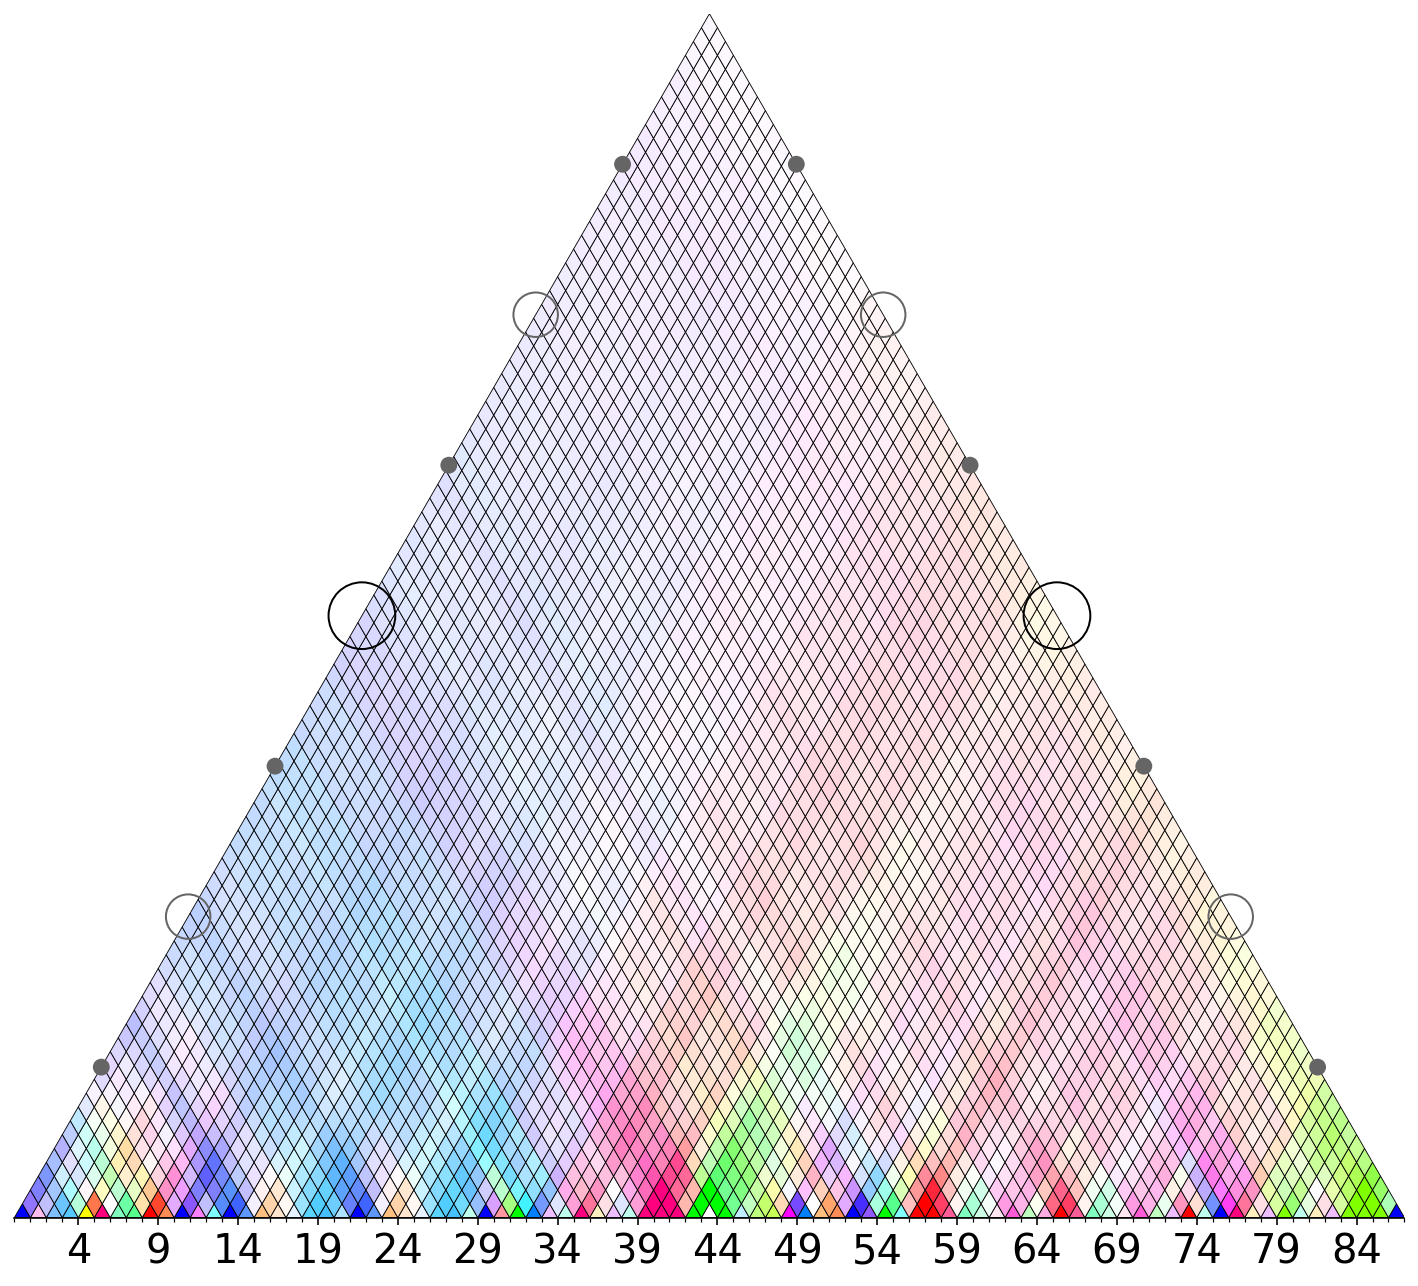

In [114]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
from matplotlib.ticker import MultipleLocator, FuncFormatter
import numpy as np

SQRT_OF_THREE = math.sqrt(3)


def rgb_to_hex(rgb):
    if type(rgb) is str and rgb[0] == '#' and len(rgb) > 6:
        # we already have an hex value given let's just return it back.
        return rgb 
    elif len(rgb) == 3:
        return '#%02x%02x%02x' % (rgb[0],rgb[1],rgb[2])
    elif len(rgb) == 4:
        return '#%02x%02x%02x%02x' % (rgb[0],rgb[1],rgb[2], rgb[3])
    else:
        raise Exception('Cannot convert RGB tuple to hex value if the value given is neither in the RGB or the RGBA format.')


class DiamondPrimitive(object):
    def __init__(self, x, y, width, height, color, bottom_diamond):
        self.half_width = width/2.
        self.half_height = height/2.
        self.x = x
        self.y = y
        self.color = color
        self.bottom_diamond = bottom_diamond
        
    def draw(self, new_color=None, stroke=None):
        curr_color = new_color if new_color else self.color
        x = self.x
        y = self.y
        # this is to treat the bottom diamond that needs to be drawn as a triangle
        last_coord = (x,y if self.bottom_diamond else y-self.half_height)
        return Polygon(((x-self.half_width, y),
                               (x, y+self.half_height),
                               (x+self.half_width, y),
                               last_coord),
                         alpha=1,
                         facecolor = curr_color,
                         edgecolor=stroke if stroke else curr_color,
                         linewidth=self.half_width/10. if stroke else None)

class HexagonPrimitive(object):
    def __init__(self, x, y, width, color):
        self.half_width = width/2.
        self.h = SQRT_OF_THREE*self.half_width/3.
        self.x = x
        self.y = y
        self.color = color

    def draw(self, new_color=None, stroke=None):
        w = self.half_width
        h = self.h
        d_x = self.x
        d_y = self.y
        curr_color = new_color if new_color else self.color
        return Polygon(((d_x+w, d_y+h),
                        (d_x, d_y+2*h),
                        (d_x-w, d_y+h),
                        (d_x-w, d_y-h),
                        (d_x, d_y-2*h),
                        (d_x+w, d_y-h)),
                         alpha=1,
                         facecolor = curr_color,
                         edgecolor=stroke if stroke else curr_color,
                         linewidth=w/20. if stroke else None)
class Wavescape(object):
    '''
    This class represent an object that holds the attributes 
    and methods needed to effectively draw the plot name "wavescape"

    Attributes
    ----------
    utm : NxNx3 or NxNx4 matrix (numpy.ndarray of numpy.uint8), 
        upper triangle matrix holding color values as tuples of 3 (RGB) or 4 (RGBA) 8 bit integers. 
        Holds the color information and their relevant informations to draw the plot.
        
    width : int
        the width in pixels of the plot. It needs to be at least twice as big as the shape of the 
        upper triangle matrix. The height of the plot is defined by the drawing primitive chosen.
        
    drawing_primitive : {'diamond', 'rhombus', 'hexagon'} , optional 
        the drawing shape that forms a single colored element from the plot. Three primitives are 
        currently available:
          -'diamond': diamond whose height is twice its width
          -'rhombus': diamond formed by two equilateral triangles. Each side is the same size
          -'hexagon': a hexagon, i.e. a 6 sides polygonal shape, each side being the same size.
        default value is 'rhombus'
    '''
    #Formula derived with a bit of algebra in order to determine the height of the wavescape hexagon plot 
    #based on the just the given plot's width (wi) and the number of layer (n). The SQRT_OF_THREE*wi was broadcasted
    #to the two parts of the addition to mitigate the numeric error caused by the division by 6 times the number
    #of layer (n).
    HEXAGON_PLOT_HEIGHT = lambda wi, n: (SQRT_OF_THREE*wi)*(0.5) + ((SQRT_OF_THREE/6.)*(wi/n))
    
    #constants 
    # fun fact that would please anyone with OCD: all drawing primitive names have the same amount of letters.
    DIAMOND_STR = 'diamond'
    RHOMBUS_STR = 'rhombus'
    HEXAGON_STR = 'hexagon'
    
    
    def __init__(self, utm, pixel_width, drawing_primitive='rhombus'):
        #dpi 96
        self.utm = utm
        self.width = pixel_width
        self.drawing_primitive = drawing_primitive
        
        mat_dim, mat_dim_other_axis, mat_depth = utm.shape
        if mat_dim != mat_dim_other_axis:
            raise Exception("The upper triangle matrix is not a square matrix")
        if mat_dim > self.width/2:
            raise Exception("The number of elements to be drawn exceeds the wavescape's resolution.(%d elements out of %d allowed by the resolution) Increase the width of the plot to solve this issue" % (mat_dim, self.width/2))
        if (mat_depth < 3 or mat_depth > 4):
            raise Exception("The upper triangle matrix given as argument does not hold either RGB or RGBA values")
        self.mat_dim = mat_dim
        
        #building a matrix with None to hold the element object for drawing them later.
        self.matrix_primitive = np.full((mat_dim, mat_dim), None, object)
        
            
        if drawing_primitive == self.HEXAGON_STR:
            self.height = Wavescape.HEXAGON_PLOT_HEIGHT(self.width, mat_dim)
            self.generate_hexagons()
        else:
            if drawing_primitive == self.RHOMBUS_STR:
                self.height = (self.width/2.) * SQRT_OF_THREE
            elif drawing_primitive == self.DIAMOND_STR:
                self.height = self.width
            else:
                raise Exception('Unkown drawing primitive: %s'%drawing_primitive)
            self.generate_diamonds()
    
    #def generate_primitives(self, prim_width, prim_height)
    
    def generate_hexagons(self):
        hexagon_width = self.width/float(self.mat_dim)
        hexagon_height = 2*SQRT_OF_THREE*hexagon_width/3.
        half_width_shift = self.width/2.
        half_height_shift = self.height/2.
        
        for y in range(self.mat_dim):
            for x in range(y, self.mat_dim):
                
                curr_color = rgb_to_hex(rgba_to_rgb(self.utm[y][x], background=(0xff,0xff,0xff)))
                #Useless to draw if there is nothing but blank to draw, duh.
                if curr_color != '#FFFFFF':
                    #classic x-axis placement taking into account the half width of the hexagon
                    d_x = hexagon_width*x
                    #Now shifting all of this to the left to go from utm placement to pyramid placement
                    d_x = d_x - hexagon_width*y/2.
                    #And finally shifting this to take into account drawSvg center placement I posed
                    d_x = d_x - half_width_shift
                    
                    d_y = hexagon_height/2.+(0.75*hexagon_height)*y
                    d_y = d_y - half_height_shift
                    
                    #self.matrix_primitive[y][x] = Hexagon(d_x, d_y, hexagon_width, curr_color)
                    self.matrix_primitive[y][x] = HexagonPrimitive(d_x, d_y, hexagon_width, curr_color)
    
    def generate_diamonds(self):
        diamond_width = self.width/float(self.mat_dim)
        diamond_height = diamond_width*2 if self.drawing_primitive != 'rhombus' else diamond_width * SQRT_OF_THREE
        
        half_width_shift = self.width/2.
        half_height_shift = self.height/2.
        
        for y in range(self.mat_dim):
            for x in range(y, self.mat_dim):
                
                curr_color = rgb_to_hex(rgba_to_rgb(self.utm[y][x], background=(0xff,0xff,0xff)))
                #Useless to draw if there is nothing but blank to draw, duh.
                if curr_color != '#FFFFFF':
                    #classic x-axis placement taking into account the edge from the diamond 
                    d_x = diamond_width*x
                    #Now shifting all of this to the left to go from utm placement to pyramid placement
                    d_x = d_x - diamond_width*y/2.
                    #And finally shifting this to take into account drawSvg center placement I posed
                    d_x = d_x - half_width_shift
                    
                    d_y = diamond_height/2.*y
                    d_y = d_y - half_height_shift
                    self.matrix_primitive[y][x] = DiamondPrimitive(d_x, d_y, \
                                          diamond_width, diamond_height, curr_color, y == 0)

    def draw(self, dpi=96, plot_indicators = True, add_line = False, tick_ratio = None):
        '''
        After being called on a properly initialised instance of a Wavescape object,
        this method draws the visual plot known as "wavescape" and return it 
        as a picture in SVG format.

        Parameters
        ----------
        plot_indicators: bool, optional 
            indicates whether rounded indicators on the lateral edges of the plot need to 
            be drawn. A rounded indicator is drawn at each eight of the height of the plot
            Default value is True
            
        dpi: int, optional
            dot per inch (dpi) of the figure. N
            Default value is 96, which is normally the dpi on windows machine. The dpi 
            
        add_line: bool, optional
            indicates whether all element of the plot (single drawing primitives) need to be
            outlined with a black line.
            Default value is False.
            
            
        tick_ratio: int, optional
            Ratio of tick per elements of the lowest level in the wavescape. If tick_ratio has value 1,
            one horizontal axis tick will be drawn per element, if it has value 2, then a tick will
            be drawn each two elements.
            Default value is None (meaning no ticks are drawn)

        Returns
        -------
        Matplotlib figure
        '''
        utm_w = self.matrix_primitive.shape[0]
        utm_h = self.matrix_primitive.shape[1]
        
        if self.matrix_primitive is None or utm_w < 1 or utm_h < 1:
            raise Exception("cannot draw when there is nothing to draw. Don't forget to generate diamonds in the correct mode before drawing.")
        
        if tick_ratio and (tick_ratio < 1 or type(tick_ratio) is not int):
            raise Exception("Tick ratio must be an integer greater or equal to 1")
        
        height = self.height
        width = self.width

        
        black_stroke_or_none = 'black' if add_line else None
        fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
        ax = fig.add_subplot(111, aspect='equal')
        primitive_half_width = None
        

        for y in range(self.matrix_primitive.shape[0]):
            for x in range(y, self.matrix_primitive.shape[1]):
                element = self.matrix_primitive[y][x]
                if x == 1 and x == y:
                    primitive_half_width = element.half_width
                ax.add_patch(element.draw(stroke=black_stroke_or_none))
                             
         
        #if add_line and self.drawing_primitive != self.HEXAGON_STR:
            #drawing using hexagons does not truncate the bottom of the plot
            #canvas.append(draw.Lines(-width/2, -height/2, width/2, -height/2,\
            #                         close=False, stroke_width=2, stroke='#000000ff'))

        if plot_indicators:
            ind_width = width if self.drawing_primitive != self.HEXAGON_STR else width + 2
            mid_size = int(self.width / 40.)
            eigth_size = int(mid_size /4.)
            quart_size = eigth_size * 3

            white_fill = (1, 1, 1, 0)
            middle_gray= (.398, .398, .398, 1)

            params = [
                {'size': mid_size,   'facecolor': white_fill, 'edgecolor': 'black' },
                {'size': quart_size, 'facecolor': white_fill, 'edgecolor': middle_gray},
                {'size': eigth_size, 'facecolor': middle_gray,'edgecolor': middle_gray}
            ]

            stroke_width = int(self.width / 1000.)+1

            
            # Code to draw the indicators using circles.
            # This is probably the most far fetched discrete mathematical formula I ever made.
            # Basically I found the coordinates relative to the height and width of the plot by trial 
            # and error using negative power of 2, and then I derived a discrete formula
            # depending on two parameters n and m (the second one depending on the first)
            # which give me automatically the right x and y coordinates. It works, just trust me.
            for n in range(1,4):
                p = params[n-1]
                for m in range(2**(n-1)):
                    x = 1/float(2**(n+1)) + m/float(2**n)
                    y = (2**n - 1)/float(2**n) - m/float(2**(n-1)) - 1/2.
                    for i in [-1, 1]:
                        ax.add_patch(Circle((i*x*width-primitive_half_width, y*height), radius=p['size'], facecolor=p['facecolor'], \
                                                  edgecolor=p['edgecolor'], linewidth=stroke_width))

        plt.autoscale(enable = True)
        
        if tick_ratio:
            scale_x = (self.width/utm_w) * tick_ratio
            ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(math.ceil((x+ self.width/2.)/scale_x)))
            ax.xaxis.set_major_formatter(ticks_x)
            ax.xaxis.set_major_locator(MultipleLocator(scale_x*5))
            #display minor indicators
            ax.xaxis.set_minor_locator(MultipleLocator(scale_x))
            
            #make all the other border invisible
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            plt.yticks([])
        else:
            plt.axis('off')

        #remove top and bottom margins 
        ax.set_ylim(bottom=-self.height/2., top=self.height/2.)
        ax.set_xlim(left=-self.width/2.-primitive_half_width, right=self.width/2.-primitive_half_width)
        plt.tight_layout()
        #return fig
        
    
    def draw_single_stripe(self, stripe_lvl, plot_delimiters=False, square_height_proportion = 1.):
        '''
        draws a single stripe of the wavescape as a line of colored rectangles
        
        Parameters
        ----------
        'stripe_lvl': int 
            indicates which level needs to be drawn as a stripe with the convention that 0
            is the lowest level.
        
        'plot_delimiters': bool, optional 
            indicates whether the rectangles are drawn with black outlines.
            Default value is False
        
        'square_height_proportion': float, optional
            represent how higher the height of the rectangle is with respect
            to his width. The individual width of each rectangle is defined
            by the attribute 'width' of the current instance, and the number 
            of elements to be drawn in the current level
            Default value is 1 (which produces squares as individual elements
            from the stripe).
            
        Returns
        -------
        drawSvg.drawing.Drawing
            A drawSvg canvas holding the drawn plot. This canvas can be saved in a svg file (using the saveSvg method
            from drawSvg.drawing.Drawing), or a png file (using the savePng method from drawSvg.drawing.Drawing)
            if the package cairosvg is installed and is functionning correctly
        '''
        
        if stripe_lvl >= self.mat_dim:
            raise Exception("The stripe's level chosen exceeds the number of layers in the plot (layers 0 to %d accessible)"%self.mat_dim-1)
        
        square_number = self.mat_dim - stripe_lvl
        square_width = self.width/square_number
        square_height = square_width * square_height_proportion
        #to account for a little bit of room to draw line delimiters on edges of the plot
        margin = 2 if plot_delimiters else 0
        canvas = draw.Drawing(self.width+margin, square_height+margin, origin='center')
        for i in range(0, self.mat_dim - stripe_lvl):
            curr_elem = self.utm[stripe_lvl][stripe_lvl+i]
            curr_color = rgb_to_hex(rgba_to_rgb(curr_elem, background=(0xff,0xff,0xff)))
            hsw = square_width/2.
            hsh = square_height/2.
            x = i*square_width + hsw - self.width/2.
            stroke = '#000000ff' if plot_delimiters else curr_color
            canvas.append(draw.Lines(x-hsw, -hsh,
                    x-hsw, hsh,
                    x+hsw, hsh,
                    x+hsw, -hsh,
                    x-hsw, -hsh, #duplicate of the first point so that it closes the square if lines are drawn
                fill=curr_color,
                stroke=stroke))
        return canvas
    
pc_mat = produce_pitch_class_matrix_from_filename(faust_symphony_midi, aw_size=1)
fourier_mat = apply_dft_to_pitch_class_matrix(pc_mat)
color_utm = complex_utm_to_ws_utm(fourier_mat, coeff=5)
w = Wavescape(color_utm, pixel_width=750, drawing_primitive='rhombus')
w.draw(plot_indicators=True, add_line=True, dpi=72, tick_ratio=1)

### Part 4.2 Legends' code

##### Part 4.2.1 (Unfinished) drawSvg version

In [12]:
def draw_circle_color_space(draw_width, lbl_pcv_d = None, opacity_step_nmbr = 50, single_coeff = None):
    
    canvas_width = draw_width
    canvas_height = draw_width
    canvas = draw.Drawing(width=canvas_width, height=canvas_height, origin="center")
    #this does not want to work the way I want and I have no idea why...
    #canvas.append(draw.Rectangle(-canvas_width,-canvas_height,canvas_width,canvas_height, fill='white'))
    lower_arc_w = 0
    higher_arc_w = 0.45*draw_width
    grey = '#777777'
    
    def dashed_coord_lines(canvas, draw_width, dash_number = int(draw_width/10)):
        dash_len = int(draw_width/dash_number)
        for i in range(1,dash_number-1):
            p1 = draw_width/2. - (dash_len*i) #+ dash_len*.25
            p2 = draw_width/2. - (dash_len*(i+.5)) #+ dash_len*.25
            canvas.append(draw.Lines(-p1, 0,
                             -p2, 0, fill='#000000', stroke=grey, stroke_width=2))
    
            canvas.append(draw.Lines(0, -p1,
                             0, -p2, fill='#000000', stroke=grey, stroke_width=2))
        
        #canvas.append(draw.Lines(higher_arc_w, 0, higher_arc_w, dash_len, fill=grey, stroke=grey))
        #canvas.append(draw.Lines(-higher_arc_w, 0, -higher_arc_w, dash_len, fill=grey, stroke=grey))
    
    opacity_step = float(higher_arc_w - lower_arc_w)/(opacity_step_nmbr)
    for angle in range(-180, 180):
        for magn in range(opacity_step_nmbr):
            color = rgb_to_hex(circular_hue(angle*(math.pi/180), magnitude=magn/float(opacity_step_nmbr)))
            p = draw.Path(fill=color)
            #+2 so that the slight overlap hides the seams. 
            p.arc(0,0,lower_arc_w+opacity_step*(magn+1) + 2,angle,angle+2)
            p.arc(0,0,lower_arc_w+opacity_step*magn,angle+1,angle,cw=True, includeL=True)
            canvas.append(p)
            
    #horizontal & vertical axis drawn   
    #dashed_coord_lines(canvas, draw_width)
    
    #borderlines of the circle
    #canvas.append(draw.Circle(0, 0, higher_arc_w,
    #            fill='ffffff', fill_opacity=0, stroke='black', stroke_width = 4))
    
    #canvas.append(draw.Text(label, text_size, x_spot, y_spot, fill='black'))
    
    color_arr = ['null', 'red', 'green', 'blue', 'yellow', 'white', 'gray']
    
    circle_size = 6
    if lbl_pcv_d:
        for lbl, tup in lbl_pcv_d.items():
            c0 = sum(tup[0])
            select_c = single_coeff if single_coeff else tup[1]
            coeff = np.fft.fft(tup[0])[select_c]
            cx = (coeff.real) * (float(higher_arc_w)/float(c0))
            cy = (coeff.imag) * (float(higher_arc_w)/float(c0))
            canvas.append(draw.Circle(cx, cy, circle_size,
                        fill=color_arr[tup[1]], fill_opacity=100, stroke='black', stroke_width = 2))
    return canvas


color_arr = ['null', 'red', 'green', 'blue', 'yellow', 'white', 'gray']

CMAJPRELUDE = {'Prelude': ([14,0,9,0,9,2,0,3,0,1,0,4], 5)}
report_fig_folder_path = 'report/5e1f16ed63eefd00018d886b/Figures/'
def legend():
    for i in range(1,len(color_arr)):
        print('Music Structure %d = %s' %(i, color_arr[i]))

##### Part 4.2.2 matplotlib version

In [13]:
type(type('str'))

type

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

d_lbls = ['$CM$','$C{\sharp}M$','$DM$','$D{\sharp}M$','$EM$','$FM$','$F{\sharp}M$','$GM$','$G{\sharp}M$','$AM$','$A{\sharp}M$','$BM$']
CMAJ = [1,0,1,0,1,1,0,1,0,1,0,1]

dlp = {d_lbls[i]: (np.roll(CMAJ, i), [5]) for i in range(len(d_lbls))}

rest_d = {
    '$C$': ([1,0,0,0,0,0,0,0,0,0,0,0], [1,5]),
    '$C\sharp$': ([0,1,0,0,0,0,0,0,0,0,0,0], [1,5]),
    '$D$': ([0,0,1,0,0,0,0,0,0,0,0,0], [1,5]),
    '$D\sharp$': ([0,0,0,1,0,0,0,0,0,0,0,0], [1,5]),
    '$E$': ([0,0,0,0,1,0,0,0,0,0,0,0], [1,5]),
    '$F$': ([0,0,0,0,0,1,0,0,0,0,0,0], [1,5]),
    '$F\sharp$': ([0,0,0,0,0,0,1,0,0,0,0,0], [1,5]),
    '$G$': ([0,0,0,0,0,0,0,1,0,0,0,0], [1,5]),
    '$G\sharp$': ([0,0,0,0,0,0,0,0,1,0,0,0], [1,5]),
    '$A$': ([0,0,0,0,0,0,0,0,0,1,0,0], [1,5]),
    '$A\sharp$': ([0,0,0,0,0,0,0,0,0,0,1,0], [1,5]),
    '$B$': ([0,0,0,0,0,0,0,0,0,0,0,1], [1,5]),
    '$C^+$': ([1,0,0,0,1,0,0,0,1,0,0,0], [3]),
    '$C\sharp^+$': ([0,1,0,0,0,1,0,0,0,1,0,0], [3]),
    '$D^+$': ([0,0,1,0,0,0,1,0,0,0,1,0], [3]),
    '$D\sharp+$': ([0,0,0,1,0,0,0,1,0,0,0,1], [3]),
    '$hex_{0,1}$': ([0,1,1,0,0,1,1,0,0,1,1,0], [3]),
    '$hex_{1,2}$': ([0,0,1,1,0,0,1,1,0,0,1,1], [3]),
    '$hex_{2,3}$': ([1,1,0,0,1,1,0,0,1,1,0,0], [3]),
    '$hex_{3,0}$': ([1,0,0,1,1,0,0,1,1,0,0,1], [3]),
    '$C^{o7}$': ([1,0,0,1,0,0,1,0,0,1,0,0], [4]),
    '$C\sharp^{o7}$': ([0,1,0,0,1,0,0,1,0,0,1,0], [4]),
    '$D^{o7}$': ([0,0,1,0,0,1,0,0,1,0,0,1], [4]),
    '$8_{0,1}$': ([1,1,0,1,1,0,1,1,0,1,1,0], [4]),
    '$8_{1,2}$': ([0,1,1,0,1,1,0,1,1,0,1,1], [4]),
    '$8_{2,0}$': ([1,0,1,1,0,1,1,0,1,1,0,1], [4]),
    '$T_0$': ([1,0,0,0,0,0,1,0,0,0,0,0], [2]),
    '$T_1$': ([0,1,0,0,0,0,0,1,0,0,0,0], [2]),
    '$T_2$': ([0,0,1,0,0,0,0,0,1,0,0,0], [2]),
    '$T_3$': ([0,0,0,1,0,0,0,0,0,1,0,0], [2]),
    '$T_4$': ([0,0,0,0,1,0,0,0,0,0,1,0], [2]),
    '$T_5$': ([0,0,0,0,0,1,0,0,0,0,0,1], [2]),
    '$WT_1$': ([1,0,1,0,1,0,1,0,1,0,1,0], [6]),
    '$WT_2$': ([0,1,0,1,0,1,0,1,0,1,0,1], [6]),
    '$\Omega$': ([1,1,1,1,1,1,1,1,1,1,1,1], [0])
}

def coeff_nbr_to_label(k):
    if type(k) == str:
        k = int(k)
    if k == 1:
        return '%dst'%k
    elif k == 2:
        return '%dnd'%k
    elif k == 3:
        return '%drd'%k
    else:
        return '%dth'%k

everything_d = dict(dlp, **rest_d)

def legend_decomposition(pcv_dict, width = 13, single_img_coeff = None):
    #TODO reduce space between labels 
    phivals = np.arange(0, 2*np.pi, 0.01)
    mu_step = .025
    muvals = np.arange(0, 1. + mu_step, mu_step)
    
    #powerset of all phis and mus.
    cartesian_polar = np.array(np.meshgrid(phivals, muvals)).T.reshape(-1, 2)
    
    #generating the color corresponding to each point.
    color_arr = []
    for phi, mu in cartesian_polar:
        hexa = rgb_to_hex(circular_hue(phi, magnitude=mu, opacity_mapping=True))
        color_arr.append(hexa)
        
    xvals = cartesian_polar[:,0]
    yvals = cartesian_polar[:,1]

    norm = mpl.colors.Normalize(0.0, 2*np.pi)
    fig = plt.figure(figsize= (width,width) if single_img_coeff else (width, 8*width/5) )
    
    def single_circle(ax, i, pcv_dict, marker_width, display_title=True):
        label_size = (marker_width/10.)
        ax.scatter(xvals, yvals, c=color_arr, s=marker_width, norm=norm, linewidths=1, marker='.')
        if display_title:
            ax.set_title(str(i)+xth_particule(i)+' coefficient', fontdict={'fontsize': label_size+6}, y=1.08)
        for k,v in pcv_dict.items():
            for coeff in v[1]:
                if coeff == i or coeff == 0:
                    comp = np.fft.fft(v[0])
                    angle = np.angle(comp[i])
                    magn = np.abs(comp[i])/np.abs(comp[0])
                    ax.scatter(angle, magn, s=marker_width, facecolors='none', edgecolors='#777777')
                    pos_magn = np.abs(magn-0.125)
                    ax.annotate(k, (angle, pos_magn), size=(marker_width/10.)+2, annotation_clip=False, horizontalalignment='center', verticalalignment='center')
        
        ax.tick_params(axis='both', which='major', labelsize=(marker_width/10.)+6)
        ax.tick_params(axis='both', which='minor', labelsize=(marker_width/10.)+4)
        ax.set_xticklabels(['$0$', '', '$\pi/2$', '', '$\pi$', '', '$3\pi/2$', ''])
        ax.set_yticks([])
        ax.spines['polar'].set_visible(False)
        ax.xaxis.grid(False)
    
    if single_img_coeff:
        ax = plt.subplot(1, 1, 1, polar=True)
        single_circle(ax=ax, i=single_img_coeff, pcv_dict=pcv_dict, marker_width=40*width, display_title=False)
    else:
        for i in range(1, 7):
            ax = fig.add_subplot(3, 2, i, polar=True)
            single_circle(ax=ax, i=i, pcv_dict= pcv_dict, marker_width=10*width)
        plt.tight_layout() #needs to be before subplot_adjust, otherwise subplot_adjust is useless.
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.3)
    return fig#fig#.tight_layout()

#### Part 4.2.3 Non Circular version of the legend, drawSvg 

In [15]:
def draw_rectangle_color_space(draw_width, add_zero_degree=True, add_labels=True, opacity_step_nmbr = 20):
    canvas_width = draw_width
    canvas_height = 0.25*draw_width
    canvas = draw.Drawing(width=canvas_width, height=canvas_height, origin="center")
    #this does not want to work the way I want and I have no idea why...
    #canvas.append(draw.Rectangle(-canvas_width,-canvas_height,canvas_width,canvas_height, fill='white'))
    lower_arc_w = 0.2*draw_width
    higher_arc_w = 0.4*draw_width
    opacity_step = float(higher_arc_w - lower_arc_w)/opacity_step_nmbr
    for angle in range(-180, 180):
        for magn in range(opacity_step_nmbr):
            opacity = int(float(0xff)*(magn/opacity_step_nmbr))
            color = rgb_to_hex(circular_hue(angle*(math.pi/180), opacity = opacity))
            p = draw.Path(fill=color)
            #+2 so that the slight overlap hides the seams. 
            p.arc(0,0,lower_arc_w+opacity_step*(magn+1) + 2,angle,angle+2)
            p.arc(0,0,lower_arc_w+opacity_step*magn,angle+1,angle,cw=True, includeL=True)
            canvas.append(p)
        
    return canvas


### Part Paper : Heatmap of some class of pc-set

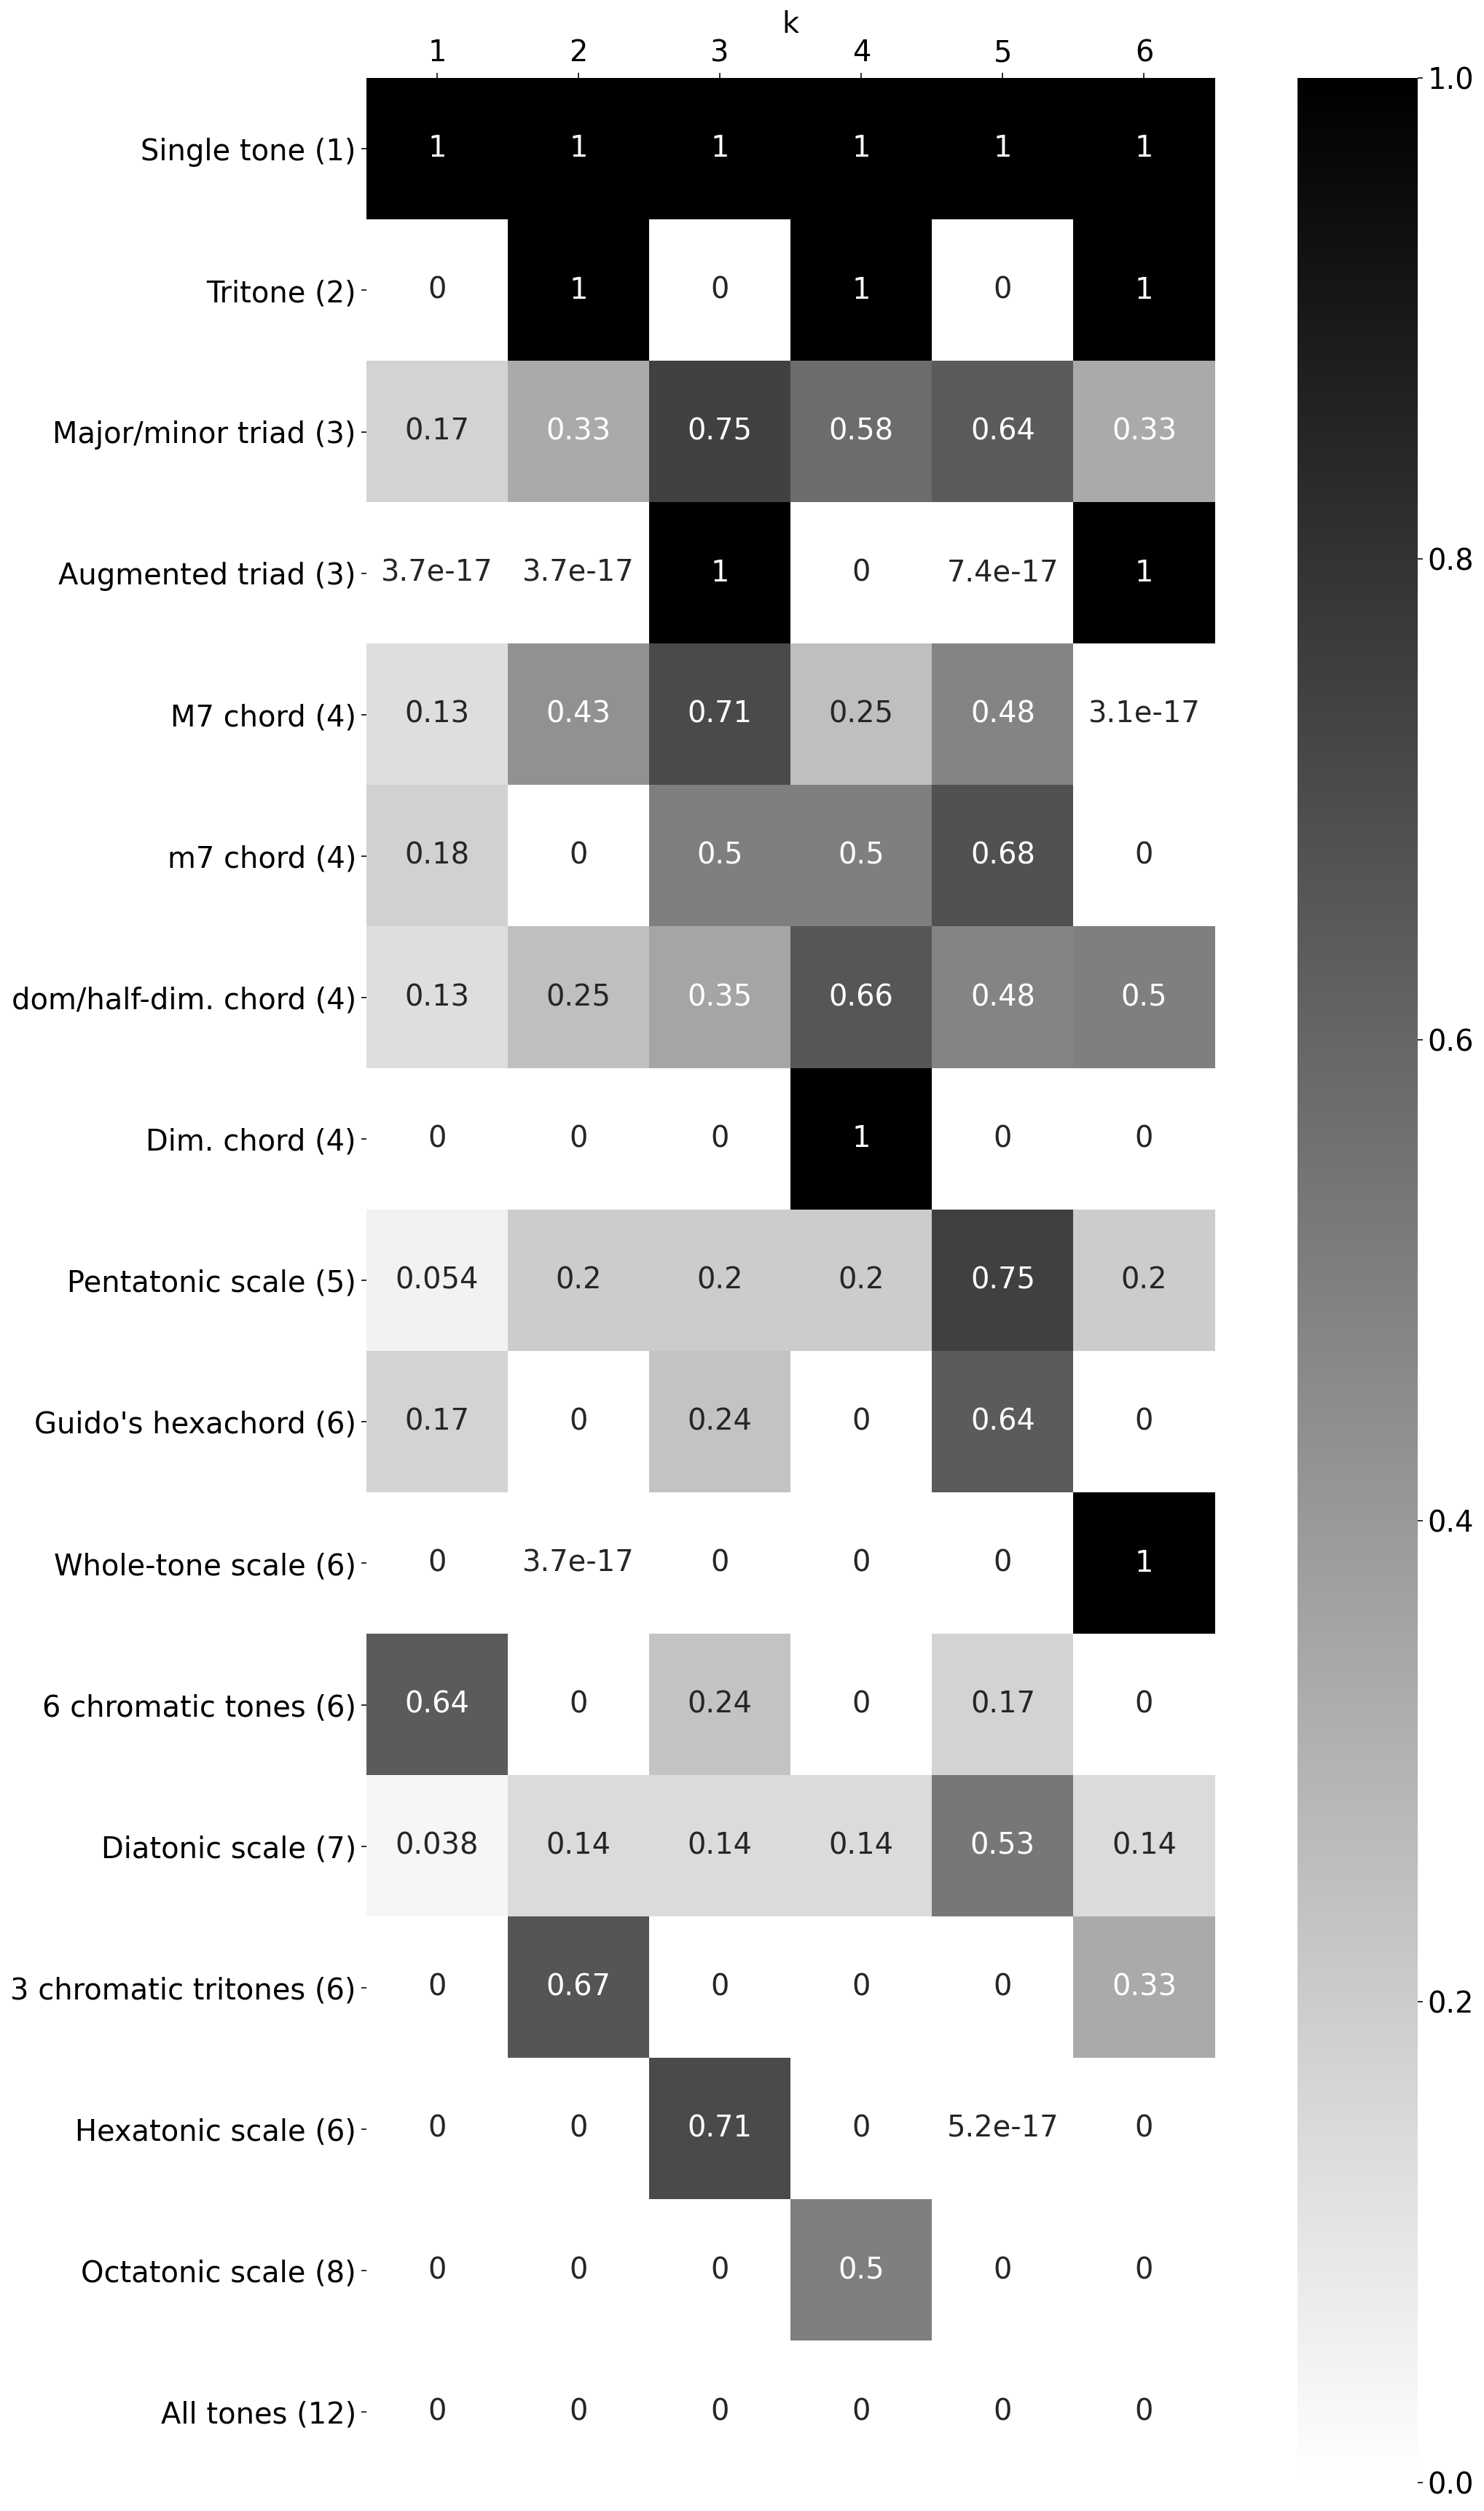

In [16]:
import seaborn as sns


nth_coeff_magn = lambda z, n: np.abs(np.fft.fft(z)[n])
total_dict = {
    'Single tone (1)' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'Tritone (2)' : [1,0,0,0,0,0,1,0,0,0,0,0],
    'Major/minor triad (3)' : [1,0,0,1,0,0,0,1,0,0,0,0],
    'Augmented triad (3)':   [1,0,0,0,1,0,0,0,1,0,0,0],
    'M7 chord (4)' : [1,0,0,0,1,0,0,1,0,0,0,1],
    'm7 chord (4)' : [1,0,0,1,0,0,0,1,0,0,1,0],
    'dom/half-dim. chord (4)' :  [1,0,0,0,1,0,0,1,0,0,1,0],
    'Dim. chord (4)': [1,0,0,1,0,0,1,0,0,1,0,0],
    'Pentatonic scale (5)': [1,0,1,0,1,0,0,1,0,1,0,0],
    'Guido\'s hexachord (6)' :[1,0,1,0,1,1,0,1,0,1,0,0],
    'Whole-tone scale (6)' : [0,1,0,1,0,1,0,1,0,1,0,1],
    '6 chromatic tones (6)': [1,1,1,1,0,0,0,0,0,0,1,1],
    'Diatonic scale (7)': [1,0,1,0,1,1,0,1,0,1,0,1],
    #'Harmonic minor scale (7)': [1,0,1,0,1,1,0,0,1,1,0,1],
    '3 chromatic tritones (6)' : [1,1,0,0,0,1,1,1,0,0,0,1],
    'Hexatonic scale (6)': [1,1,0,0,1,1,0,0,1,1,0,0],
    'Octatonic scale (8)': [1,1,0,1,1,0,1,1,0,1,1,0],
    'All tones (12)': [1,1,1,1,1,1,1,1,1,1,1,1]
}

coeffs_1_to_6 = {str(i):i for i in range(1,7)}


def heatmap_plotting(labels_in_vec_dict, coeffs_dict, normalization=True, figsize = (16, 24), epsilon=.0001):
    labelsize= 20
    plt.figure(figsize=figsize)
    mpl.rc('xtick', labelsize=labelsize) 
    mpl.rc('ytick', labelsize=labelsize)
    
    labels = list(labels_in_vec_dict.keys())
    vectors = list(labels_in_vec_dict.values())
    coeffs = list(coeffs_dict.values())
    x_len = len(labels)
    y_len = len(coeffs)
    matrice = np.full((x_len, y_len), 0.0, np.float32)
    for i in range(x_len):
        for j in range(y_len):
            vec = vectors[i]
            coeff = coeffs[j]
            norm_magn = nth_coeff_magn(vec, coeff)/(sum(vec) if normalization else 1.0)
            norm_magn = norm_magn #if norm_magn > epsilon else 0.
            matrice[i][j] = norm_magn

    cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
    ax = sns.heatmap(matrice, yticklabels=labels, xticklabels=list(coeffs_dict.keys()), square=True, cmap=cmap, annot=True, annot_kws={"size": labelsize})
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xlabel('k', fontsize=labelsize)
    return ax

heatmap_plotting(total_dict, coeffs_1_to_6)
plt.tight_layout()

### Part Bonus: Hexagon formed by 6 wavescapes.

In [17]:
def generate_all_coeffs_image(dft_utm, resolution, plot_indicators=True):
    return {str(i): Wavescape(complex_utm_to_ws_utm(dft_utm, i, opacity_mapping=True),\
                              resolution).draw(plot_indicators=plot_indicators, add_bg = False)\
            for i in range(1,7)}

def scaleImg(img):
    size_w = img.size[0]
    half_size_w = int(size_w/2.)
    size_h = img.size[1]
    #half_size_h = int(size_h/2.)
    canvas = Image.new('RGBA', (size_w*2, size_h*2), (0xff, 0xff,0xff, 0x00))
    #third argument of paste if the mask. In our case we use the image again as a mask, for not having the backgroun being drawn in white. 
    canvas.paste(img, (half_size_w, size_h), img)
    return canvas



#on windows, that part require cairo to be installed. It is considerablz harder to make it work on windows than on
#any other OS. To make it work, follow this tutorial https://weasyprint.readthedocs.io/en/stable/install.html, 
#and DONT CHEAT. Follow everything as it is explained under the "Windows" section
def build_super_hexagon_picture(coeff_img_dict):
    prev_img = None
    temp_dir = tempfile.TemporaryDirectory()
    for i in range(1,7):
        coeff = str(i)
        curr_ws = coeff_img_dict[coeff]
        save_filename = temp_dir.name+'tmpWs'+coeff+'.png'
        curr_ws.savePng(save_filename)
        #60*(i+1) so that the first coeff. wavescape starts in
        curr_img = scaleImg(Image.open(save_filename).convert('RGBA')).rotate(60*(i+1))
        if prev_img:
            prev_img.paste(curr_img, (0,0), curr_img)
            del curr_img
        else:
            prev_img = curr_img
    return prev_img

#as of yet, is experimental.
def build_super_hexagon_pitcure_cairoless(coeff_img_dict):
    from svglib.svglib import svg2rlg
    from reportlab.graphics import renderPM
    prev_img = None
    temp_dir = tempfile.TemporaryDirectory()
    for i in range(1,7):
        coeff = str(i)
        print(coeff)
        curr_ws = coeff_img_dict[coeff]
        save_filename = temp_dir.name+'tmpWs'+coeff
        curr_ws.saveSvg(save_filename+'.svg')
        drawing = svg2rlg(save_filename+'.svg')
        save_filename += '.png'
        renderPM.drawToFile(drawing, save_filename)
        #60*(i+1) so that the first coeff. wavescape starts in
        curr_img = scaleImg(Image.open(save_filename).convert('RGBA')).rotate(60*(i+1))
        if prev_img:
            prev_img.paste(curr_img, (0,0), curr_img)
            del curr_img
        else:
            prev_img = curr_img
    return prev_img


### Part bonus 2 : classic 6 wavescapes display in one image

In [18]:

def add_label_top_left_corner_of_canvas(canvas, label, plot_width, plot_height):
    text_size = 0.75*(plot_width/10) # we want the text to be displayed on one tenth of the plot's size
    x_spot = -2*(plot_width)/5.
    y_spot = 2*(plot_height)/5.
    canvas.append(draw.Text(label, text_size, x_spot, y_spot, fill='black'))
    return canvas

def six_wavescapes_collage(filepath, aw_size, plot_resolution=None, remove_percussions = True, \
                           plot_indicators = True, drawing_primitive='rhombus', horizontal_orientation = True, first_bar = None):
    
    pcv_arr = produce_pitch_class_matrix_from_filename(filepath=filepath, aw_size=aw_size, remove_percussions=remove_percussions)
    print(len(pcv_arr))
    if first_bar:
        pcv_arr = pcv_arr[:first_bar]
    dft_utm = apply_dft_to_pitch_class_matrix(pcv_arr)
    
    #avoid too small drawing resolution for the wavescapes.
    if not plot_resolution: 
        plot_resolution = (len(pcv_arr)*3) * 2
        print('No width provided for the plot, using %d instead \
        (6 times the amount of elements to draw in the base level of each wavescape)'%plot_resolution)
    elif plot_resolution < int(len(pcv_arr)*6.):
        
        print('The drawing width given for the plot (%d) is smaller than twice the amount of element to draw per wavescape (%d * 3 * 2).\
        the plot width  of %d has been chosen instead'%(plot_resolution, len(pcv_arr), len(pcv_arr)*6))
        plot_resolution = (len(pcv_arr)*3) * 2
              
    ws_resolution = int(plot_resolution/3.)
    
    label_ws_dict = {str(i): Wavescape(complex_utm_to_ws_utm(dft_utm, i, opacity_mapping=True),\
                              ws_resolution, drawing_primitive=drawing_primitive).draw(plot_indicators=plot_indicators)\
                    for i in range(1,7)}
    
    folder = tempfile.TemporaryDirectory()
    temp_filepath = folder.name+'tmp_ws'
    single_ws_height = None
    for k, v in label_ws_dict.items():
        coeff_label = coeff_nbr_to_label(k) + ' coef.'
        single_ws_height = v.height
        add_label_top_left_corner_of_canvas(v, coeff_label, ws_resolution, single_ws_height).savePng(temp_filepath+k+'.png')
    
    get_coeff_nmbr = lambda k: k.split('_')[-1].replace('c','')
    nmbr_ws_dict = {int(get_coeff_nmbr(k)):Image.open(temp_filepath+k+'.png').convert('RGB')\
            for k,_ in label_ws_dict.items()} 

    
    if horizontal_orientation:
        total_width = plot_resolution
        total_height = int(single_ws_height * 2)
        canvas = Image.new('RGB', (total_width, total_height), (0xff, 0xff,0xff))
        #top row (1c, 2c, 3c)
        for i in range(3):
            curr_ws = nmbr_ws_dict[i+1]
            canvas.paste(curr_ws, (ws_resolution*i, 0))
        #bottom row (4c, 5c, 6c)
        for j in range(3,6):
            curr_ws = nmbr_ws_dict[j+1]
            canvas.paste(curr_ws, (ws_resolution*(j-3), int(single_ws_height)))
    else:
        total_width = ws_resolution * 2
        total_height = int(single_ws_height * 3)
        canvas = Image.new('RGB', (total_width, total_height), (0xff, 0xff,0xff))
        #top row (1c, 2c)
        for i in range(2):
            curr_ws = nmbr_ws_dict[i+1]
            canvas.paste(curr_ws, (ws_resolution*i, 0))
        #middle row (3c, 4c)
        for j in range(2,4):
            curr_ws = nmbr_ws_dict[j+1]
            canvas.paste(curr_ws, (ws_resolution*(j-2), int(single_ws_height)))
        #borrom row (5c, 6c)
        for k in range(4,6):
            curr_ws = nmbr_ws_dict[k+1]
            canvas.paste(curr_ws, (ws_resolution*(k-4), int(single_ws_height)*2))
    return canvas

filenames=['210606-Prelude_No._1_BWV_846_in_C_Major']
#for f in filenames:
fmidi = test_midi_folder + filenames[0] + '.mid'
res = six_wavescapes_collage(fmidi, aw_size=1, plot_resolution=2000, drawing_primitive='rhombus', horizontal_orientation=True)
res

140


AttributeError: 'NoneType' object has no attribute 'height'

Error in callback <function flush_figures at 0x11e5a6f80> (for post_execute):


KeyboardInterrupt: 

In [ ]:
pcv_arr = produce_chromagrams_from_audio_file(bach_prelude_midi, aw_size=4)
dft_utm = apply_dft_to_pitch_class_matrix(pcv_arr)
color_utm = complex_utm_to_ws_utm(dft_utm)
w = Wavescape(color_utm)

### For the impatient: single use case, with only default parameters.

In [ ]:
pcv_array = produce_pitch_class_matrix_from_filename(bach_prelude_midi)
fourier_mat = apply_dft_to_pitch_class_matrix(pcv_array)
coeff_mat = complex_utm_to_ws_utm(fourier_mat, 5)
ws = Wavescape(coeff_mat, 500)

ws.draw()

### For the impatient: 

In [ ]:
import scipy

def zeroth_coeff_cm(value, coeff):
        zero_c = value[0].real
        if zero_c == 0.:
            #empty pitch class vector, thus returns white color value.
            #this avoid a nasty divide by 0 error two lines later.
            return (0.,0.)#([0xff]*3
        nth_c = value[coeff]
        magn = np.abs(nth_c)/zero_c
        angle = np.angle(nth_c)
        return (angle, magn)

res = []

for f in filenames:
    pc_mat = produce_pitch_class_matrix_from_filename(f)
    fourier_mat = apply_dft_to_pitch_class_matrix(pc_mat)
    shape_x, shape_y = np.shape(fourier_mat)[:2]
    print(f)
    one_res = [f.split('/')[1].split('.')[0].replace('_', ' ')]
    for coeff in range(1,7):
        all_magn = []
        for y in range(shape_y):
            for x in range(shape_x):
                _, magn = zeroth_coeff_cm(fourier_mat[y][x], coeff)
                if magn > 0.:
                    all_magn.append(magn)

        stats = scipy.stats.describe(all_magn)
        magn_str = '{:.3f}'.format(stats.mean).lstrip('0')
        var_str = '{:.3f}'.format(stats.variance).lstrip('0')
        one_res.append('$%s(\pm%s)$'%(magn_str, var_str))
        #print('coeff %d - avg: %.4f, std_dv: %.4f'%(coeff, stats.mean, stats.variance))
    print(one_res)
    res.append(one_res)
        
#res[y][x] = circular_hue(angle, magnitude=magn, opacity_mapping = opacity_mapping)
#res = build_super_hexagon_picture(generate_all_coeffs_image(fourier_mat, 1000, plot_indicators=False))
#res

In [ ]:
import pandas as pd
df = pd.DataFrame(res).T
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header
print(df.to_latex().replace('textbackslash ', '').replace('\$', '$'))

In [ ]:
pc_mat = produce_pitch_class_matrix_from_filename(bach_prelude_midi)
fourier_mat = apply_dft_to_pitch_class_matrix(pc_mat)
for i in range(1,7):
    for
    print(np.shape(fourier_mat.shape[::i]))

### Bonus : Keyscape on Bach's prelude & faust symphony

In [ ]:
import pylab
#twelve_tones_major_key_names = ['C','D$\\flat$','D','E$\\flat$','E','F','G$\\flat$','G','A$\\flat$','A','B$\\flat$','B']
twelve_tones_major_key_names = ['C','D$\\flat$','D','E$\\flat$','E','F','G$\\flat$','G','A$\\flat$','A','B$\\flat$','B']
twelve_tones_minor_key_names = ['c','c$\sharp$','d','e$\\flat$','e','f','f$\sharp$','g','g$\sharp$','a','b$\\flat$','b']

temperley_maj = [5.0, 2.0, 3.5, 2.0, 4.5, 4.0, 2.0, 4.5, 2.0, 3.5, 1.5, 4.0]
temperley_min = [5.0, 2.0, 3.5, 4.5, 2.0, 4.0, 2.0, 4.5, 3.5, 3.0, 1.5, 4.0]

krumhansl_maj = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
krumhansl_min = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

temperley_minor_keys = [np.roll(temperley_min, i) for i in range(len(temperley_min))]
temperley_major_keys = [np.roll(temperley_maj, i) for i in range(len(temperley_maj))]

krumhansl_minor_keys = [np.roll(krumhansl_min, i) for i in range(len(krumhansl_min))]
krumhansl_major_keys = [np.roll(krumhansl_maj, i) for i in range(len(krumhansl_maj))]

def nth_coeff_phase(input_vec, n_coeff):
    assert(n_coeff <= len(input_vec))
    if not np.any(input_vec):
        return white_value
    dft_nth_coeff = np.fft.fft(input_vec)[n_coeff]
    return np.angle(dft_nth_coeff)

temperley_major_angle_dict = {k: nth_coeff_phase(v, 5) for k, v in zip(twelve_tones_major_key_names, temperley_major_keys)}
temperley_minor_angle_dict = {k: nth_coeff_phase(v, 5) for k, v in zip(twelve_tones_minor_key_names, temperley_minor_keys)}

temperley_major_color_dict = {k: circular_hue(v) for k,v in temperley_major_angle_dict.items()}
#half the opacity 
temperley_minor_color_dict = {k: circular_hue(v, magnitude=.5) for k,v in temperley_major_angle_dict.items()}

krumhansl_major_angle_dict = {k: nth_coeff_phase(v, 5) for k, v in zip(twelve_tones_major_key_names, krumhansl_major_keys)}
krumhansl_minor_angle_dict = {k: nth_coeff_phase(v, 5) for k, v in zip(twelve_tones_minor_key_names, krumhansl_minor_keys)}

krumhansl_major_color_dict = {k: circular_hue(v) for k,v in krumhansl_major_angle_dict.items()}
minor_colors = [circular_hue(v, magnitude=.5) for v in krumhansl_major_angle_dict.values()]
krumhansl_minor_color_dict = dict(zip(np.roll(list(krumhansl_minor_angle_dict.keys()), 3), minor_colors))


def scalar_product(input_vec, key_prof, shift_idx):
    # compute the scalar product between a pitch class (input_vec),
    # and a key profile starting at C (key_prof). The argument "shift_idx"
    # indicates at which pitch should the scalar product begin according to the 
    # key profile.
    acc = 0
    pitch_class_size = len(key_prof)
    for i in range(pitch_class_size):
        acc += input_vec[i]*key_prof[(i-shift_idx)%pitch_class_size]
    return acc

def select_best_key_sp(input_vec, key_prof_maj, key_prof_min):
    #returns a tuple of type int and boolean: (key_index, isMajor)
    
    result_array_maj = np.array([ scalar_product(input_vec, key_prof_maj, i) for i in range(len(key_prof_maj))])
    result_array_min = np.array([ scalar_product(input_vec, key_prof_min, i) for i in range(len(key_prof_min))])
    key_idx = np.argmax(np.vstack([result_array_maj, result_array_min]))
    #np.argmax return only a singular index, regardless of the array shape, meaning that above 11, that
    #that means the key was identified in the second row, i.e. the minor key.
    return (key_idx % 12, key_idx < 12)    

def pitch_to_color_template_matching(pitch_class_vector, major_profile, minor_profile, major_colors, minor_colors):
    if not np.any(pitch_class_vector):
        #this means the vector only has 0 values.
        return [255,255,255]
    key, is_major = select_best_key_sp(pitch_class_vector, major_profile, minor_profile)
    pitch_to_rgb = None
    if is_major:
        pitch_to_rgb = major_colors.values() 
    else:
        m = list(minor_colors.values())
        pitch_to_rgb = m[:9]+m[9:]
        
    indexes = [i for i in range(len(pitch_to_rgb))]
    index_to_rgb = dict(zip(indexes, pitch_to_rgb))
    return index_to_rgb[key]


temperley_color_mapping = lambda pcv: pitch_to_color_template_matching(pcv, temperley_maj, temperley_min, temperley_major_color_dict, temperley_minor_color_dict)
krumhansl_color_mapping = lambda pcv: pitch_to_color_template_matching(pcv, krumhansl_maj, krumhansl_min, krumhansl_major_color_dict, krumhansl_minor_color_dict)



def pcv_array_to_keyscape(pcv_array, color_mapping):
    pcv_nmb = len(pcv_array)
    
    res_vector = np.full((pcv_nmb, pcv_nmb, 12), 0.0, np.float64)
    res_vector[0] = pcv_array
    pcv_mat = build_utm_from_one_row(res_vector)
    
    res_mat = np.full((pcv_nmb, pcv_nmb, 3), (0xff), np.uint8)
    for i in range(0, pcv_nmb):
        for j in range(0, pcv_nmb):
            color = color_mapping(pcv_mat[i][j])
            res_mat[i][j] = color
    return res_mat

def color_mapping_color_legend(major_label_color_dict, minor_label_color_dict, plot_width=20):
    keys_nbr = len(major_label_color_dict)
    marker_size = (2.*(plot_width+2))/(3*keys_nbr)
    plot_height = 3*marker_size
    xs = np.arange(0,plot_width,1.5*marker_size)
    bottom_y = 0
    top_y = 1.5*marker_size
    ys = [top_y, bottom_y]
    fig, ax = plt.subplots(figsize=(plot_width-1.5,plot_height))
    
    
    major_label_color = np.array([[k,v] for k,v in major_label_color_dict.items()])
    minor_label_color = np.array([[k,v] for k,v in minor_label_color_dict.items()])
    colors_mat = np.array((order_by_fifth(major_label_color[:,1]),\
                           order_by_fifth(minor_label_color[:,1])))
    labels_mat = np.array((order_by_fifth(major_label_color[:,0]), \
                           order_by_fifth(minor_label_color[:,0])))
    
    for i in range(len(ys)):
        curr_colors = colors_mat[i]
        curr_labels = labels_mat[i]
        for j in range(len(xs)):
            curr_color = rgb_to_hex(curr_colors[j])
            rect = mpl.patches.Rectangle((xs[j],ys[i]),marker_size,marker_size,linewidth=1,facecolor=curr_color)
            #ha = horizontal alignment, va = vertical alignment
            plt.text(xs[j]+marker_size/2., ys[i]+marker_size/2., curr_labels[j], va='center', ha='center', fontsize=30)#, horizontalignment='center')
            ax.add_patch(rect)
    plt.axis('off')
    pylab.axis('scaled')
    
def order_by_fifth(input_vec):
    one_elem_type = type(input_vec[0])
    zero_elem = '' if one_elem_type is str else 0
    res = [zero_elem]*len(input_vec)
    for i in range(len(input_vec)):
        curr_elem = input_vec[i]
        res[(i*7)%12] = curr_elem
    #centering on C Major
    return res[6:]+res[:6]


pcv_array = produce_pitch_class_matrix_from_filename(faust_symphony_midi)

color_mat = pcv_array_to_keyscape(pcv_array, krumhansl_color_mapping)
ws = Wavescape(color_mat, 500, drawing_primitive='rhombus')

color_mapping_color_legend(krumhansl_major_color_dict, krumhansl_minor_color_dict)
plt.tight_layout()
plt.savefig('color_legend.png')
#ws.draw().savePng('faust_ks_kr.png')


In [ ]:
import pylab
axes = pylab.axes()
circle1 = pylab.Circle((0,0), radius=20, alpha=.5)
circle2 = pylab.Circle((0.5,0.5), radius=20, alpha=.5)
axes.add_patch(circle1)
axes.add_patch(circle2)
pylab.axis('scaled')
pylab.show()